In [28]:
import numpy as np                                                                        
import matplotlib.pyplot as plt
import pyCloudy as pc
import pyneb as pn
from astropy    import constants as const
from astropy.io import ascii
import pandas as pd
from scipy import interpolate
import warnings
from scipy.integrate import quad, IntegrationWarning
import scipy.integrate as integrate
from numpy import log10, exp
import os
from astropy.constants import c
import astropy.units as u
from scipy import special

kpc = const.kpc.cgs.value

atom = ['Lya','HeII','CIV']

def read_file(path_way, atom):
    Mod = pc.CloudyModel(path_way, cloudy_version_major=23)
    Mod.ionic_names

    N_H = sum(Mod.dr*Mod.nH)
    # solar_metallicitiy from von Steiger et al. 2016
    frac_He = 0.085 #E-01
    frac_C = 4.47E-04
    frac_O = 6.61E-04
    frac_N = 9.33E-05
    frac_Mg = 7.08E-05

    N_HI = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',0))
    N_HII = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',1))
    N_HeII = frac_He*sum(Mod.dr*Mod.nH*Mod.get_ionic('He',1))
    N_OVI = frac_O*sum(Mod.dr*Mod.nH*Mod.get_ionic('O',5))
    N_NV = frac_N*sum(Mod.dr*Mod.nH*Mod.get_ionic('N',4))
    N_CIV = frac_C*sum(Mod.dr*Mod.nH*Mod.get_ionic('C',3))

    num = len(Mod.nH)
    r_CIV = path_way +  '.ele_C'
    f = open(r_CIV,'r')
    header = f.readline()
    CIV_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[4])
        CIV_frac[i] = j
        i = i + 1

    r_He = path_way +  '.ele_He'
    f = open(r_He,'r')
    header = f.readline()
    HeII_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[2])
        HeII_frac[i] = j
        i = i + 1




    n_H= Mod.nH
    n_He = n_H*frac_He
    n_C = n_H*frac_C
    nden_CIV = CIV_frac*n_C
    nden_HeII = HeII_frac*n_He

    # print('Lya Luminosity = ',float(Mod.get_emis_vol('H__1_121567A')) )
    # print('HeII Luminosity = ',float(Mod.get_emis_vol('HE_2_164043A')) )
    # print('CIV Luminosity = ',float(Mod.get_emis_vol('C__4_154819A')) + float(Mod.get_emis_vol('C__4_155078A')) )

    if atom == 'CIV':
        Cloudy_Lum = float(Mod.get_emis_vol('C__4_154819A')) + float(Mod.get_emis_vol('C__4_155078A'))
        Cloudy_emis = (Mod.get_emis('C__4_154819A')) + (Mod.get_emis('C__4_155078A'))
        Cloudy_den = nden_CIV
    elif atom == 'Lya':
        Cloudy_Lum= float(Mod.get_emis_vol('H__1_121567A'))
        Cloudy_emis = Mod.get_emis('H__1_121567A')
        Cloudy_den = n_H
    elif atom == 'HeII':
        Cloudy_Lum = float(Mod.get_emis_vol('HE_2_164043A'))
        Cloudy_emis = Mod.get_emis('HE_2_164043A')
        Cloudy_den = nden_HeII
    return Cloudy_Lum , Cloudy_emis ,Cloudy_den

def radius(path, atom):
    Mod = pc.CloudyModel(path, cloudy_version_major=23)
    radius = Mod.radius/kpc
    radius_kpc =Mod.radius 
    dr = Mod.dr 
    return radius, radius_kpc, dr

def make_data_file(path,atom):
    lum ,emis ,den = read_file(path,atom)
    radius_R , radius_kpc , dr=  radius(path,atom)
    tt =  pd.DataFrame(np.column_stack((radius_R,emis,den)))
    tt.to_csv('/home/jin/RT/RT_main/{}_cloudy.txt'.format(atom), sep='\t',index=False,header =False)
    tt.to_csv('/home/jin/RT/RT_scat/{}_cloudy.txt'.format(atom), sep='\t',index = False,header=False)
    return print("make data file!")





def SB(z, radius_kpc, emissivity, dr):
    r_min, r_max = radius_kpc.min(), radius_kpc.max()
    Project_R = np.linspace(0, 100, 70) * kpc
    N = len(Project_R)
    surface_brightness = np.zeros(N)
    Lumin = np.zeros(N)

    from scipy.interpolate import interp1d
    emis_interp = interp1d(radius_kpc, emissivity, bounds_error=False, fill_value=0)
    
    for ii, R in enumerate(Project_R):
        # 적분 함수 정의
        def integrand(r):
            if r < R:
                return 0
            else:
                emis = emis_interp(r)
                return emis * r / np.sqrt(r**2 - R**2)
            
        surface_brightness[ii], _ = quad(integrand, R, r_max)
        surface_brightness[ii] *= 2 / (1+z)**4
    dR =  Project_R[1] - Project_R[0]    
    def lumin_integrand(R):
        if R == 0 :
            area = np.pi * (0.5*dR)**2
        elif R == r_max:
            area = np.pi * (2*R +0.5*dR)*0.5*dR 
        else:
            area = 2 * np.pi * R * np.interp(R, Project_R, surface_brightness)
        
        return area
    
    Lumin, _ = quad(lumin_integrand, 0, r_max)
    
    return Project_R / kpc, surface_brightness, Lumin

def RT_SB(path):
    name = ['radius','SB_K','SB_H','SB_tot','1','2','3']
    data_sp = pd.read_csv(path, sep='\s+', header=None,names=name)
    rad, SB_t, SB_k,SB_h =  data_sp['radius'].to_numpy(),data_sp['SB_tot'].to_numpy(),data_sp['SB_K'].to_numpy(),data_sp['SB_H'].to_numpy()
    return rad*100, rad*100*kpc, SB_t 

def find_y(x_find,x,y):
    ii = int(np.where(x <= x_find)[0][-1])
    # print(ii)
    y_find = (y[ii+1] -y[ii]) / (x[ii+1] - x[ii])*(x_find - x[ii]) + y[ii]
    return y_find




warnings.filterwarnings("ignore", category=IntegrationWarning)

path_LT = r'/home/jin/RT/RT_main/data_CLOUDY_setting/OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT For CIV

RT_path_HeII =r'/home/jin/RT/RT_main/data_HeII_wo_s/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'
RT_path_CIV = r'/home/jin/RT/RT_main/data_CIV_wo_s/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'


# make_data_file(path_LT,'CIV')
# make_data_file(path_LT,'HeII')

# ! pip install pyneb


In [29]:
rr = np.arange(12, 18, 1)
atom = [13,20,32,50,79]
rr_reshaped = rr.reshape(-1, 1)
total_N_c = 10**rr_reshaped * atom / 10
total_N_c = total_N_c.flatten()

C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm

C_IV_K_A = 1548.187  # cm
C_IV_H_A = 1550.772  # cm

cc = c.to(u.cm / u.s).value  # cm/s
cc_k = c.to(u.km / u.s).value #km / s
v_th_CIV = 11.7673179819719e5  # cm/s

K_gamma = 2.65e+8
H_gamma = 2.64e+8
f_CIV_K = 0.190
f_CIV_H = 0.0952

lam_c =  (C_IV_K_A + C_IV_H_A) / 2

voigt_path_11_8 = r'/home/jin/RT/RT_main/CIV_Voigt_data/CIV_Voigt_11_8.txt'
voigt_path_30 = r'/home/jin/RT/RT_main/CIV_Voigt_data/CIV_Voigt_30.txt'
voigt_path_50 = r'/home/jin/RT/RT_main/CIV_Voigt_data/CIV_Voigt_50.txt'

NN = int(1e4)


C_IV_N = np.linspace(1e12, 1e17, NN)

def N_esc_scat(line,voigt_path,v_th):


    name = ['lambda','sigma']
    voigt_file = pd.read_csv(voigt_path,sep='\s+',names=name,)
    lam_0, scat_0 = voigt_file['lambda'].to_numpy() , voigt_file['sigma'].to_numpy()

    del_V =  ((lam_0-C_IV_K) / C_IV_K) * cc /1e5
    x =   del_V / (v_th/1e5)
    K_H_center = 250  / (v_th/1e5)
    dx = x[1] - x[0]
    x_K = x[np.where(x <= K_H_center)[0]]
    x_H = x[np.where(x >= K_H_center)[0]]
    scat_K = scat_0[np.where(x <= K_H_center)[0]]
    scat_H = scat_0[np.where(x >= K_H_center)[0]]
    x_0 = np.zeros(NN)

    xx_K = 0
    xx_H = 500/ (v_th/1e5)

    if line =='K' or line =='k' :
        x = x_K
        scat = scat_K
        xx_c = xx_K
        ii = np.where( (x > -dx/2) & (x < dx/2) )[0]
        cross_sec_cen, N_CIV_cen =  (scat[ii]) ,1/scat[ii]

    elif line == 'H' or line =='h' :
        x = x_H 
        scat = scat_H
        xx_c = xx_H
        jj = np.where( (x > xx_H -dx/2) & (x < xx_H +dx/2) )[0]
        cross_sec_cen, N_CIV_cen =  (scat[jj]) ,1/scat[jj]



    tau_profile = np.outer(C_IV_N, scat)
    
    # print(line,'scattering cross-section = ', cross_sec_cen )
    print(line,'Center  Columne density = ', N_CIV_cen  )


    for ii, jj in enumerate(C_IV_N):
        x_p = np.where(np.diff(np.sign(1 - tau_profile[ii, :])))[0]
        x_0[ii] = x[x_p].max() if x_p.size > 0 else 0


    V_del_peak = 2*abs( (x_0 - xx_c)*(v_th/1e5))

    del_lam_D = v_th / C_IV_K
    nu_0_K= cc/C_IV_K
    nu_esc = x_0*del_lam_D + nu_0_K
    # V_del_peak = 2 * abs((nu_esc - nu_0_K)/nu_0_K) * cc/1e5 #km/s
    v_esc = x_0*v_th
    N_esc= 1/special.erfc(v_esc/v_th)

    
    return x ,tau_profile , V_del_peak , N_esc


def calculate_order_and_value(value):

    if value == 0 :
        return "000" , 0
    elif value == 1:
        return int(value * 100), 0
    elif value < 100:
        return int(value * 10), 1
    elif value < 1000:
        return int(value), 2
    else :
        return int(value / 10), 3


#combine K and H lines
def data_sp_com(Line , atom_num , atom_index, vout, vemit, vran):
    out, out_order = calculate_order_and_value(vout)
    emit, emit_order = calculate_order_and_value(vemit)
    ran , ran_order = calculate_order_and_value(vran)

    path = r'/home/jin/data_CIV/N_atom{}0E+{}_Vexp{}E+0{}_Vemit{}E+0{}_tauD000E+00_Vran{}E+0{}spec_com.dat'.format(atom_num, atom_index , out, out_order, emit, emit_order, ran, ran_order)
    try:
        data = pd.read_csv(path, sep='\s+', header=None)
    except:
        print('파일을 찾을 수 없습니다.',path)


    lam = data[0].to_numpy()
    spec_tot = data[1].to_numpy() # total photon
    spec_sc = data[2].to_numpy()  # scattering photon
   # spec_pol_tot = data[3]  # polization of the total photon
   # spec_pol_scat = data[4]  $ polization of the scattering photon
    return lam , spec_tot , spec_sc



#separate K and H line
def data_sp(Line , atom_num , atom_index, vout, vemit, vran):
    out, out_order = calculate_order_and_value(vout)
    emit, emit_order = calculate_order_and_value(vemit)
    ran , ran_order = calculate_order_and_value(vran)

    path = r'/home/jin/data_CIV/N_atom{}0E+{}_Vexp{}E+0{}_Vemit{}E+0{}_tauD000E+00_Vran{}E+0{}spec.dat'.format(atom_num, atom_index , out, out_order, emit, emit_order, ran, ran_order)
    try:
        data = pd.read_csv(path, sep='\s+', header=None)
    except:
        print('파일을 찾을 수 없습니다.',path)


    x = data[0].to_numpy()
    if Line == 'h' or Line =='H':
        lam = -  C_IV_H_A / ( (vran/cc_k)*x -1)
        spec_tot = data[2].to_numpy()
        spec_scat = data[4].to_numpy()

    elif Line == 'k' or Line =='K':
        lam = - C_IV_K_A / ( (vran/cc_k)*x -1)
        spec_tot = data[1].to_numpy()
        spec_scat = data[3].to_numpy()       

    
    return lam , spec_tot , spec_scat


def data_scat(Line , atom_num , atom_index, vout, vemit, vran):
    out, out_order = calculate_order_and_value(vout)
    emit, emit_order = calculate_order_and_value(vemit)
    ran , ran_order = calculate_order_and_value(vran)

    path = r'/home/jin/data_CIV/N_atom{}0E+{}_Vexp{}E+0{}_Vemit{}E+0{}_tauD000E+00_Vran{}E+0{}_f_esc.dat'.format(atom_num, atom_index , out, out_order, emit, emit_order, ran, ran_order)
    try:
        data = pd.read_csv(path, sep='\s+', header=None)
    except:
        print('파일을 찾을 수 없습니다.',path)

    if Line == 'k' or Line =='K':
        N_sct = data.iloc[0,4]

    elif Line == 'h' or Line =='H':
        N_sct = data.iloc[0,5]

    return N_sct
    


def K_H_from_Combine_data(Line , atom_num , atom_index, vout, vemit, vran):
    lam , spec_tot , spec_halo =  data_sp_com(Line , atom_num , atom_index, vout, vemit, vran)
    if Line == 'k' or Line =='K':
        ioc = np.where(lam<=lam_c)[0]
        lam_x = lam[ioc]
        spec_tot_x = spec_tot[ioc]
        spec_halo_x  = spec_halo[ioc]

    elif Line == 'h' or Line =='H':
        ioc = np.where(lam>=lam_c)[0]
        lam_x = lam[ioc]
        spec_tot_x = spec_tot[ioc]
        spec_halo_x  = spec_halo[ioc]
    else :
        lam_x  = lam 
        spec_tot_x = spec_tot
        spec_halo_x = spec_halo

    return lam_x , spec_tot_x , spec_halo_x

lam, spec_tot , spec_halo = K_H_from_Combine_data('all',50,14,200,400,100)
# plt.plot(lam,spec_tot)
# plt.axvline(x=1549,ymin=0,ymax=2)

from scipy.signal import find_peaks

# 빛의 속도 (km/s)

def del_v_peaks(Line, atom_num, atom_index, vout, vemit, vran):
    lam, spec_tot, spec_halo = data_sp_com(Line, atom_num, atom_index, vout, vemit, vran)

    # 모든 피크 찾기
    peaks, properties = find_peaks(spec_halo)

    if len(peaks) < 2:
        # 피크가 2개 미만이면 del_v = 0
        del_v = 0
        peak_lambda = []
        peak_values = []
    else:
        # 모든 피크 중 강도 높은 상위 2개 선택
        peak_intensities = spec_halo[peaks]
        top_2_indices = np.argsort(peak_intensities)[-2:]  # 가장 강한 2개의 피크 선택
        top_2_indices = peaks[top_2_indices]  # 원래 인덱스로 변환

        # 피크 파장 및 강도
        peak_lambda = lam[top_2_indices]
        peak_values = spec_halo[top_2_indices]

        # 기준 파장 설정 (C_IV_K_A, C_IV_H_A는 미리 정의되어 있어야 함)
        if Line in ['k', 'K']:
            lambda_0 = C_IV_K_A
        elif Line in ['h', 'H']:
            lambda_0 = C_IV_H_A
        else:
            raise ValueError("Invalid Line input. Must be 'k' or 'h'.")

        # **추가: 피크 강도 차이가 10,000 이상이면 double peak이 아님**
        if abs(peak_values[0] - peak_values[1]) > 20000  or abs(peak_lambda[0] - peak_lambda[1]) < 0.05 :
            del_v = 0
        else:
            # 속도 변환 (v = c * (lambda - lambda_0) / lambda_0)
            peak_velocities = cc_k * (peak_lambda - lambda_0) / lambda_0
            del_v = abs(peak_velocities[1] - peak_velocities[0])  # 속도 차이 계산

    return del_v, peak_lambda



def doublet_ratio(Line, atom_num, atom_index, vout, vemit, vran):
    lam_K , spec_tot_K , spec_halo_K = K_H_from_Combine_data('k', atom_num, atom_index, vout, vemit, vran)
    lam_H , spec_tot_H , spec_halo_H = K_H_from_Combine_data('h', atom_num, atom_index, vout, vemit, vran)

    cut_off_K = np.where(lam_K > (C_IV_K_A-lam_c))[0]
    cut_off_H = np.where(lam_H < (C_IV_H_A+lam_c))[0]

    spec_tot_K = spec_tot_K[cut_off_K]
    spec_tot_H = spec_tot_H[cut_off_H]

    doublet_line_ratio = np.sum(spec_tot_K) / np.sum(spec_tot_H)

    return doublet_line_ratio


def lam_to_vel(lam):
    vel = (lam - C_IV_K_A) * cc_k / C_IV_K_A   # km/s
    return vel

In [30]:
path_LT = r'/home/jin/RT/RT_main/data_CLOUDY_setting/OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT For CIV

RT_path_HeII =r'/home/jin/RT/RT_main/data_HeII_wo_s/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'
RT_path_CIV = r'/home/jin/RT/RT_main/data_CIV_wo_s/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'
RT_path_Lya =r'/home/jin/RT/RT_main/data_HeII_wo_s/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'
atom_N = ['Lya','HeII','CIV']

def make_parameter(path,RT_path,atom):
    z_red_Shift = 0
    globals()['{}_radius'.format(atom)] , globals()['{}_radius_kpc'.format(atom)], globals()['dr_{}'.format(atom)] = radius(path,atom)
    globals()['{}_lum'.format(atom)] , globals()['{}_emis'.format(atom)] , globals()['{}_den'.format(atom)] = read_file(path,atom)
    globals()['{}_rt_radius'.format(atom)] , globals()['{}_rt_radius_kpc'.format(atom)], globals()['{}_rt_sb_t'.format(atom)] = RT_SB(RT_path)
    globals()['{}_p_radius'.format(atom)] , globals()['{}_SB'.format(atom)], globals()['{}_lum_SB'.format(atom)] = SB(z_red_Shift,globals()['{}_radius_kpc'.format(atom)],globals()['{}_emis'.format(atom)]  , globals()['dr_{}'.format(atom)]) # , globals()['rt_radius_kpc_{}'.format(atom)]
    return print("make parameters of {}".format(atom))

for atom in atom_N:
    make_parameter(path_LT,globals()['RT_path_{}'.format(atom)],atom)



def photon_number_SB(radius,origin_SB):
    R_rt =  radius/ 100 
    dR = R_rt[1] - R_rt[0]
    number_dis= np.zeros(len(R_rt))
    surface_brightness_RT = np.zeros(len(R_rt))
    for ii, R in enumerate(R_rt):
        if R == 0 :
            area = np.pi * (0.5*dR)**2
        elif R ==R_rt[-1]:
            area = np.pi * (2*R +0.5*dR)*0.5*dR 
        else :
            area = 2*np.pi*R*dR
        number_dis[ii] = origin_SB[ii] * area 
        
    total_Number = np.sum(number_dis).astype(int)
    factor_atom = CIV_lum / total_Number 
    
    for ii, R in enumerate(R_rt):
        if R == 0 :
            area = np.pi * (0.5*dR)**2
        elif R ==R_rt[-1]:
            area = np.pi * (2*R +0.5*dR)*0.5*dR 
        else :
            area = 2*np.pi*R*dR
        factor_area = (100*kpc)**2
        surface_brightness_RT[ii] = number_dis[ii] * factor_atom / (area*factor_area) 




    return number_dis , surface_brightness_RT

    

make parameters of Lya
make parameters of HeII
make parameters of CIV


<Figure size 1000x700 with 0 Axes>

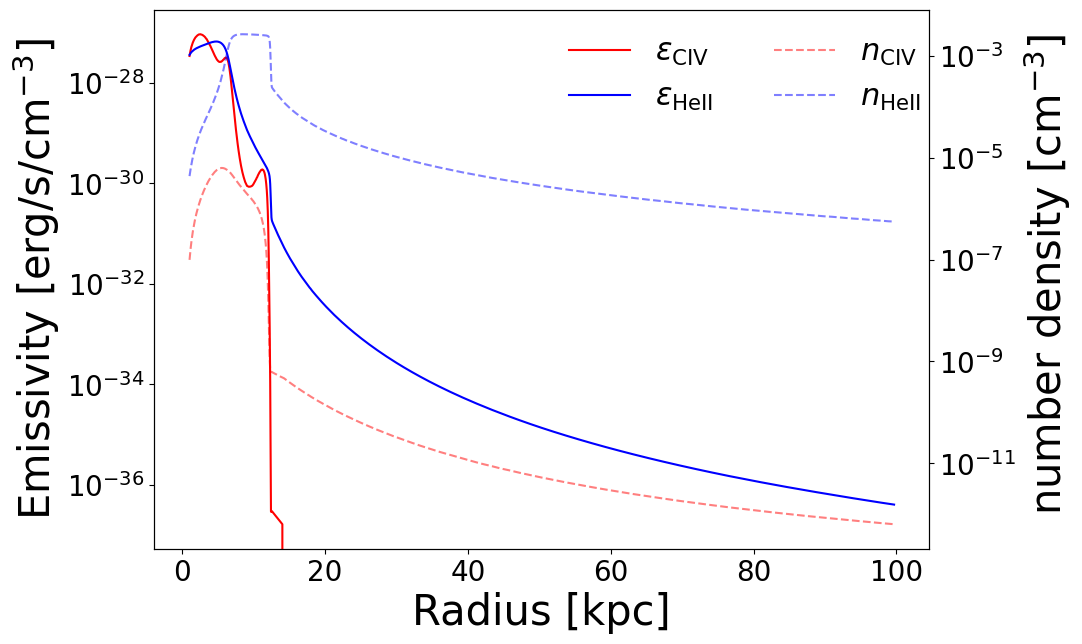

In [31]:
fig = plt.figure(1, figsize=(10,7))

fig, ax1 = plt.subplots(figsize=(10, 7))  # fig와 ax1 생성
ax2 = ax1.twinx()  # ax1의 오른쪽에 ax2 추가

ax1.plot(CIV_radius, CIV_emis ,'r-',label=r'$\epsilon_{\rm CIV}$')

ax2.plot(CIV_radius, CIV_den, 'r--',alpha = 0.5, label=r'$n_{\rm CIV}$')

ax1.plot(HeII_radius, HeII_emis ,'b-',label=r'$\epsilon_{\rm He II}$')

ax2.plot(HeII_radius, HeII_den, 'b--',alpha = 0.5, label=r'$n_{\rm He II}$')

ax1.set_xlabel('Radius [kpc]',fontsize=30)

ax1.set_ylabel(r'$\rm Emissivity \  [\rm erg/s/cm^{-3}]$',fontsize = 30)
ax2.set_ylabel(r' $\rm number \ density \ [\rm cm^{-3}]$ ',fontsize = 30)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)


ax1.set_yscale('log')
ax2.set_yscale('log')

# 두 개의 축에서 legend 정보를 가져오기
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# 통합된 범례를 오른쪽 위에 배치
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0.5, 1.0),ncol=2 ,fontsize=22, frameon=False)




In [32]:

def calculate_order_and_value(value):
    """ 주어진 값에 대해 변환된 값과 해당 order 반환 """

    if value == 0 :
        return "000" , 0
    elif value == 1:
        return int(value * 100), 0
    elif value < 100:
        return int(value * 10), 1
    elif value < 1000:
        return int(value), 2

    return int(value / 10), 3


def RT_make_parameter(v_out, v_emit, v_rand, atom):
    # 기본값 설정
    radius_RT, radius_kpc_RT, SB_RT = np.array([0]), np.array([0]), np.array([0])
    radius_CL, sb_CL = np.array([0]), np.array([0])
    normal_RT, normal_CL = 1, 1  # ZeroDivisionError 방지

    if v_out == 0:
        expand, vout_order = "000", 0
    else:
        expand, vout_order = v_out, 2
    # print(v_emit)
    emit, emit_order = calculate_order_and_value(v_emit)    
    # print(emit,emit_order)
    rand, rand_order = calculate_order_and_value(v_rand)
    # print(rand)

    # 파일 경로 설정
    #ubuntu
    path_rt = (f'/home/jin/RT/RT_main/data_CIV_w_s/N_atom000E+00_'
                f'Vexp{expand}E+0{vout_order}_Vemit{emit}E+0{emit_order}_'
                f'tauD000E+00_Vran{rand}E+0{rand_order}radi.dat')
    #window
    # path_rt = (f'/home/jin/RT/RT_main/sb_cloudy/data_RT/N_atom000E+00_'
    #             f'Vexp{expand}E+0{vout_order}_Vemit{emit}E+0{emit_order}_'
    #             f'tauD000E+00_Vran{rand}E+0{rand_order}radi.dat')


    # RT_SB 함수 호출
    rt_output = RT_SB(path_rt)
    if rt_output is not None:
        radius_RT, radius_kpc_RT, SB_RT = rt_output

    # SB_RT 값이 None이거나 비어있을 경우 기본값 설정
    if SB_RT is None or len(SB_RT) == 0:
        SB_RT = np.array([0])
    normal_RT = np.sum(SB_RT) if np.sum(SB_RT) != 0 else 1

    print(f"make parameters of v_rand = {v_rand} km/s, v_exp = {v_out} km/s, v_emit = {v_emit} km/s for {atom}")

    # 추가 데이터 처리
    z_red_Shift = 0
    radius_data = radius(path_LT, atom)
    lum_data = read_file(path_LT, atom)
    sb_data = SB(z_red_Shift, radius_data[1], lum_data[1], radius_data[2])

    if sb_data is not None:
        radius_CL, sb_CL = sb_data[0], sb_data[1]

    # sb_CL 값이 None이거나 비어있을 경우 기본값 설정
    if sb_CL is None or len(sb_CL) == 0:
        sb_CL = np.array([0])
    normal_CL = np.sum(sb_CL) if np.sum(sb_CL) != 0 else 1

    return radius_RT, radius_kpc_RT,  SB_RT/ normal_RT, SB_RT   


def vout_make_parameter(v_out, v_emit ,v_rand):
    for ii in v_out:
        nn = int(ii / 100)
        globals()['RT_radius_vout_{}'.format(nn)] , globals()['RT_radius_kpc_vout_{}'.format(nn)], globals()['RT_SB_vout_{}'.format(nn)] , globals()['Or_RT_SB_vout_{}'.format(nn)]= RT_make_parameter(ii, v_emit, v_rand,'CIV')[:4]
    return print("Make data!!")


def vemit_make_parameter(v_out, v_emit ,v_rand):
    for ii , jj in enumerate (v_emit):
        nn = int(jj / 10)
        globals()['RT_radius_vemit_{}'.format(nn)] , globals()['RT_radius_kpc_vemit_{}'.format(nn)], globals()['RT_SB_vemit_{}'.format(nn)] , globals()['Or_RT_SB_vout_{}'.format(nn)]= RT_make_parameter(v_out, jj, v_rand,'CIV')[:4]
    return print("Make data!!")


def vrand_make_parameter(v_out, v_emit ,v_rand):
    for ii , jj in enumerate(v_rand):
        nn = int(jj / 10)
        globals()['RT_radius_vrand_{}'.format(nn)] , globals()['RT_radius_kpc_vrand_{}'.format(nn)], globals()['RT_SB_vrand_{}'.format(nn)], globals()['Or_RT_SB_vout_{}'.format(nn)] = RT_make_parameter(v_out, v_emit, jj,'CIV')[:4]
    return print("Make data!!")


In [33]:
vout = np.array([0,100,200,300,400,500,600,800])
vemit = 100
vrand = 30
vout_make_parameter(vout,vemit,vrand)

make parameters of v_rand = 30 km/s, v_exp = 0 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 30 km/s, v_exp = 100 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 30 km/s, v_exp = 200 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 30 km/s, v_exp = 300 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 30 km/s, v_exp = 400 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 30 km/s, v_exp = 500 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 30 km/s, v_exp = 600 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 30 km/s, v_exp = 800 km/s, v_emit = 100 km/s for CIV
Make data!!


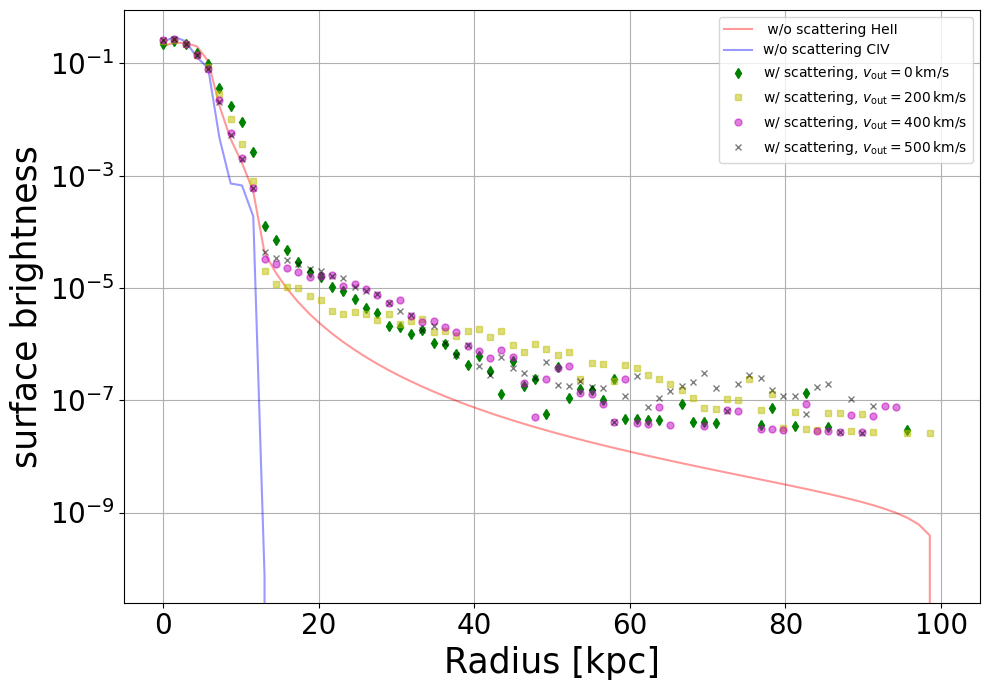

In [34]:
fig = plt.figure(1,figsize=(10,7))



plt.plot(HeII_p_radius ,HeII_SB/np.sum(HeII_SB),'r-',alpha = 0.4,label=' w/o scattering HeII')
plt.plot(CIV_p_radius ,CIV_SB/np.sum(CIV_SB),'b-',alpha = 0.4,label='w/o scattering CIV')




plt.plot(RT_radius_vout_0 ,RT_SB_vout_0,'gd',ms=5,label=r'w/ scattering, $v_{\rm out} = 0 \, \rm km/s$')



plt.plot(RT_radius_vout_2 ,RT_SB_vout_2,'ys',ms=5, alpha = 0.5, label=r'w/ scattering, $v_{\rm out} = 200 \, \rm km/s$')

plt.plot(RT_radius_vout_4 ,RT_SB_vout_4,'mo',ms=5, alpha = 0.5, label=r'w/ scattering, $v_{\rm out} = 400 \, \rm km/s$')

plt.plot(RT_radius_vout_5 ,RT_SB_vout_5,'kx',ms=5, alpha = 0.5, label=r'w/ scattering, $v_{\rm out} = 500 \, \rm km/s$')
# plt.plot(RT_radius_6 ,RT_SB_6,'b*', label=r'w/ scattering, $v_{\rm out} = 600 km/s$')


# plt.xlim(0,15)

plt.grid(True)
plt.yscale('log')
plt.xlabel('Radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()



# plt.savefig(r'/home/jin/바탕화면/outflow_case.png')

0.32329497166108806


(-300.0, 800.0)

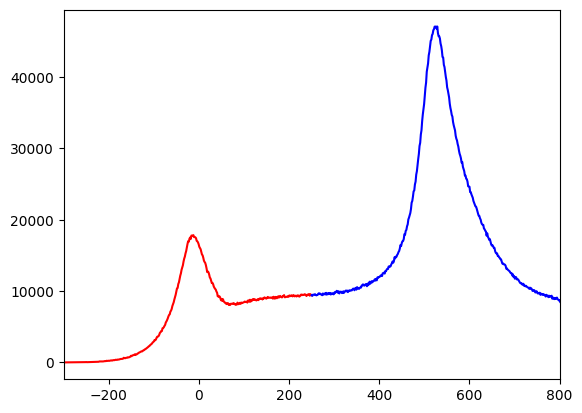

In [35]:
atom , index , vout, vemit, vrand= 32, 15 , 500 , 100 , 30
lam_K, spec_tot_K , spec_halo_K = K_H_from_Combine_data('K',atom, index, vout, vemit, vrand) 
lam_H, spec_tot_H , spec_halo_H = K_H_from_Combine_data('H',atom, index, vout, vemit, vrand) 
doublet_ratio_R = doublet_ratio('H',atom, index, vout, vemit, vrand)
print(doublet_ratio_R)
plt.plot(lam_to_vel(lam_K), spec_tot_K,'r-')
plt.plot(lam_to_vel(lam_H), spec_tot_H,'b-')

plt.xlim(-300,800)
 


0.09418665514813082
Luminosity of CIV =  1.5578665190756982e+40
Luminosity of HeII =  2.295801249360609e+40


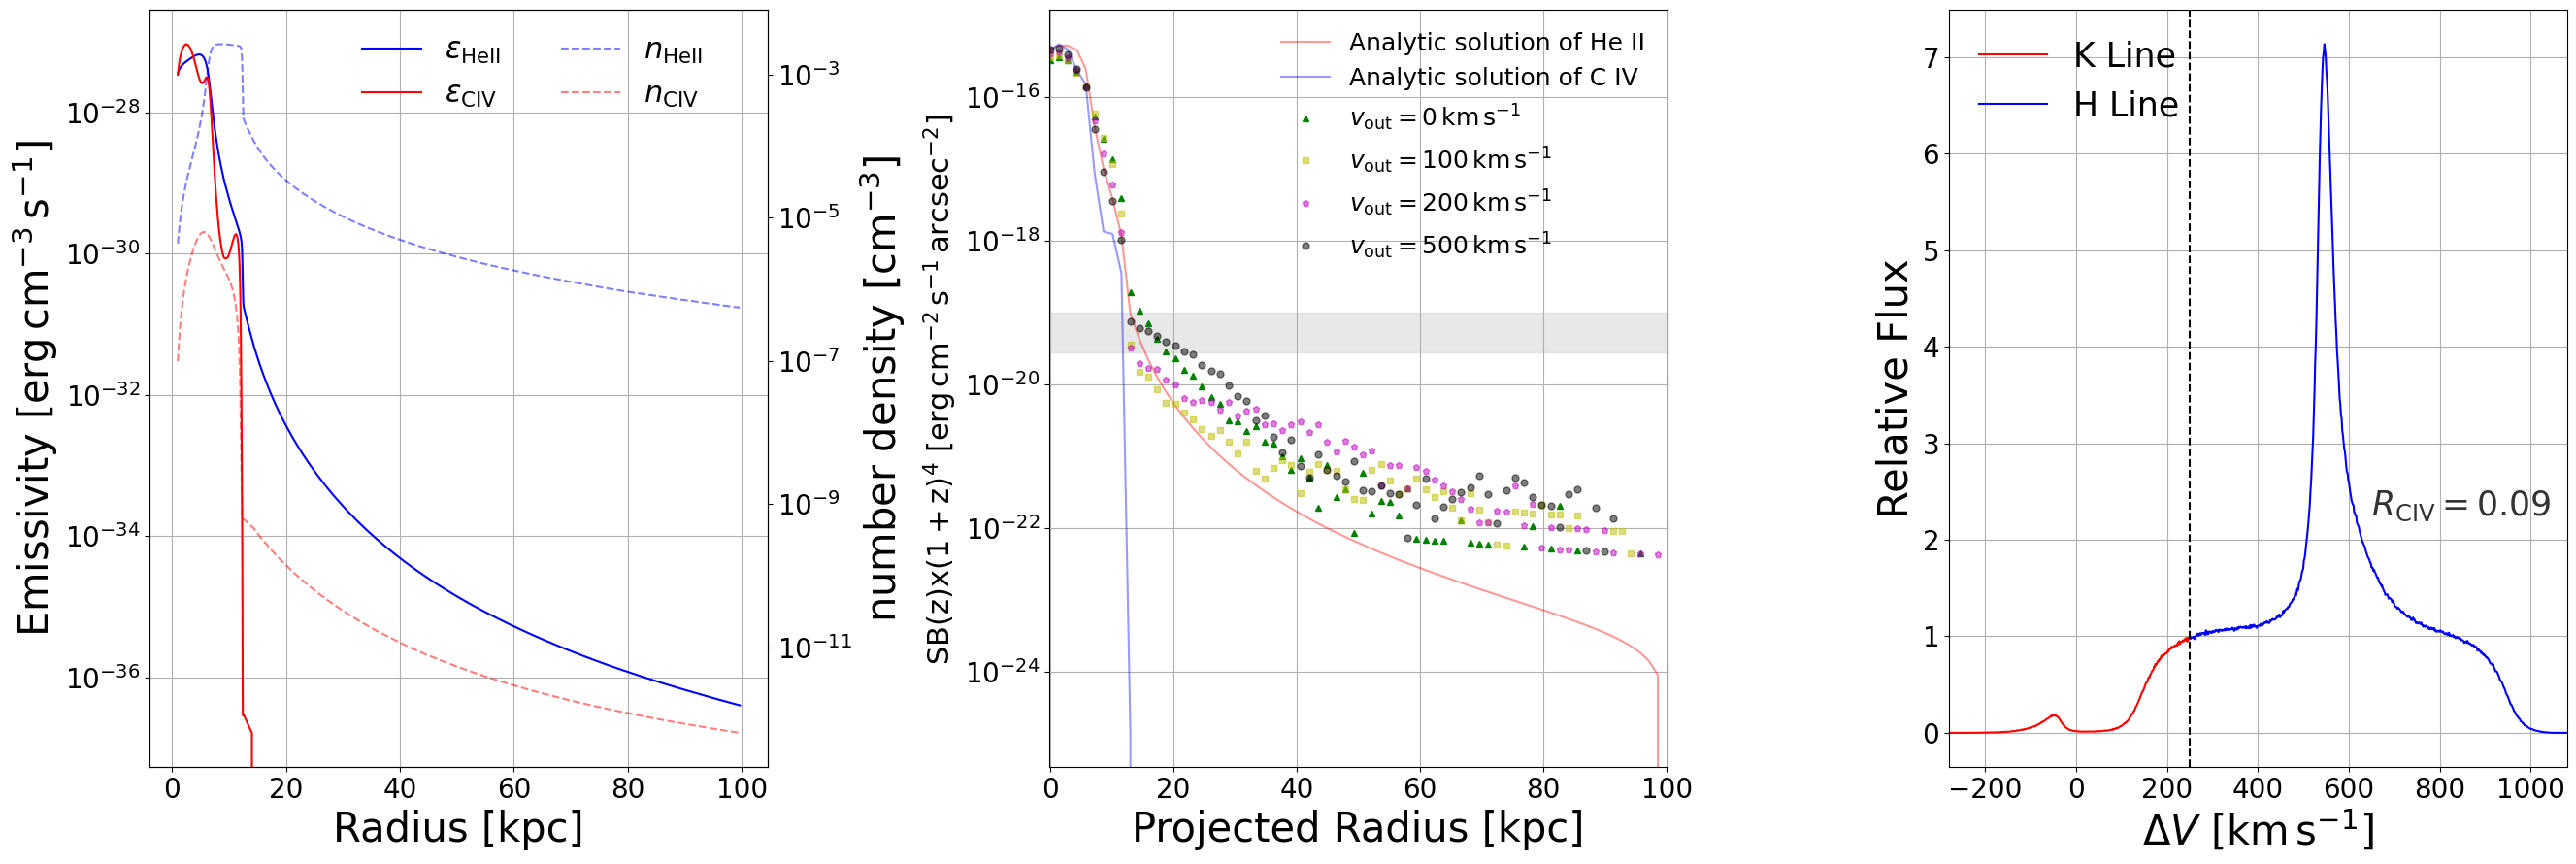

In [36]:
# 전체 figure 및 subplot 설정
fig, ax = plt.subplots(1, 3, figsize=(27, 9))

labelsize = 30
ticksize= 20
legendsize = 22

plt.subplots_adjust(wspace=0.7)

### 첫 번째 subplot ###
ax1 = ax[0]
ax2 = ax1.twinx()  # 오른쪽 y축 추가



ax1.plot(HeII_radius, HeII_emis ,'b-',label=r'$\epsilon_{\rm He II}$')
ax2.plot(HeII_radius, HeII_den, 'b--', alpha=0.5, label=r'$n_{\rm He II}$')

ax1.plot(CIV_radius, CIV_emis ,'r-',label=r'$\epsilon_{\rm CIV}$')
ax2.plot(CIV_radius, CIV_den, 'r--', alpha=0.5, label=r'$n_{\rm CIV}$')

ax1.set_xlabel('Radius [kpc]', fontsize=labelsize)
ax1.set_ylabel(r'$\rm Emissivity \  [\rm erg \, cm^{-3} \, s^{-1}]$', fontsize=labelsize)
ax2.set_ylabel(r'$\rm number \ density \ [\rm cm^{-3}]$', fontsize=labelsize)

ax1.tick_params(axis='x', labelsize=ticksize)
ax1.tick_params(axis='y', labelsize=ticksize)
ax2.tick_params(axis='y', labelsize=ticksize)

ax1.grid(True)

ax1.set_yscale('log')
ax2.set_yscale('log')

# 범례 설정
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0.3, 1.0), ncol=2, fontsize=legendsize, frameon=False)


### 두 번째 subplot ###
sr_to_arc = (180*3600 / np.pi)**2

ax[1].set_yscale('log')

# NaN 방지 (np.sum()이 0일 경우 대비)
HeII_SB_norm = HeII_SB / np.sum(HeII_SB) if np.sum(HeII_SB) != 0 else HeII_SB
CIV_SB_norm = CIV_SB / np.sum(CIV_SB) if np.sum(CIV_SB) != 0 else CIV_SB

ax[1].plot(HeII_p_radius, HeII_SB/sr_to_arc, 'r-', alpha=0.4, label='Analytic solution of He II')
ax[1].plot(CIV_p_radius, CIV_SB/sr_to_arc, 'b-', alpha=0.4, label='Analytic solution of C IV')
# ax[1].plot(Lya_p_radius, Lya_SB/sr_to_arc, 'k-', alpha=0.4, label='Analytic solution of Lya')

z = 0
red_shift_f = (1+z)**4

ax[1].plot(RT_radius_vout_0, photon_number_SB(RT_radius_vout_0, Or_RT_SB_vout_0)[1]/sr_to_arc * red_shift_f , 'g^', ms=5, label=r'$v_{\rm out} = 0 \, \rm km \, s^{-1}$')
ax[1].plot(RT_radius_vout_1, photon_number_SB(RT_radius_vout_1, Or_RT_SB_vout_1)[1]/sr_to_arc * red_shift_f , 'ys', ms=5, alpha=0.5, label=r'$v_{\rm out} = 100 \, \rm km \, s^{-1}$')
ax[1].plot(RT_radius_vout_2, photon_number_SB(RT_radius_vout_2, Or_RT_SB_vout_2)[1]/sr_to_arc * red_shift_f , 'mp', ms=5, alpha=0.5, label=r'$v_{\rm out} = 200 \, \rm km \, s^{-1}$')
ax[1].plot(RT_radius_vout_5, photon_number_SB(RT_radius_vout_5, Or_RT_SB_vout_5)[1]/sr_to_arc * red_shift_f , 'ko', ms=5, alpha=0.5, label=r'$v_{\rm out} = 500 \, \rm km \, s^{-1}$')

# 500
# Limited SB of MUSE -> Augustin et al. 2019
ax[1].fill_between([-0.1,100.1], 1e-19, 2.8e-20, color='lightgray', alpha=0.5)



# photon_number_SB(RT_radius_vout_0, RT_SB_vout_0)

ax[1].grid(True)
ax[1].set_xlabel('Projected Radius [kpc]', fontsize=labelsize)
ax[1].set_ylabel(r'$\rm SB(z) x (1+z)^4$ $\rm [erg \, cm^{-2} \,s^{-1}\, arcsec^{-2} ]$ ', fontsize=labelsize-8)
ax[1].set_xlim(-0.1,100.1)

ax[1].tick_params(axis='x', labelsize=ticksize)
ax[1].tick_params(axis='y', labelsize=ticksize)
ax[1].legend(fontsize=18,frameon=False)



## 3번째 subplot 

atom , index , vout, vemit, vrand= 50, 16 , 500 , 100 , 30
lam_K, spec_tot_K , spec_halo_K = K_H_from_Combine_data('K',atom, index, vout, vemit, vrand) 
lam_H, spec_tot_H , spec_halo_H = K_H_from_Combine_data('H',atom, index, vout, vemit, vrand) 
doublet_ratio_R = doublet_ratio('H',atom, index, vout, vemit, vrand)
print(doublet_ratio_R)
ax[2].plot(lam_to_vel(lam_K), spec_tot_K / max(spec_tot_K),'r-',label='K Line')
ax[2].plot(lam_to_vel(lam_H), spec_tot_H / max(spec_tot_K),'b-',label='H Line')
ax[2].axvline(x=250,ymin=0,ymax=1,linestyle='--',color='k')
ax[2].text(650, 2.25, s=rf'$R_{{\rm CIV}} = {doublet_ratio_R:.2f}$', size=25,alpha=0.8)


ax[2].grid(True)
ax[2].set_xlabel(r'$\Delta V$ $\rm[km\,s^{-1}]$', fontsize=labelsize)
ax[2].set_ylabel('Relative Flux', fontsize=labelsize)
ax[2].tick_params(axis='x', labelsize=ticksize)
ax[2].tick_params(axis='y', labelsize=ticksize)
ax[2].set_xlim(-280,1080)
ax[2].legend(fontsize=25, frameon=False)
plt.tight_layout()

print('Luminosity of CIV = ' ,CIV_lum)
print('Luminosity of HeII = ' ,HeII_lum)


# plt.savefig(r'/mnt/c/Users/wlsdl/OneDrive/바탕 화면/plot_result.png')

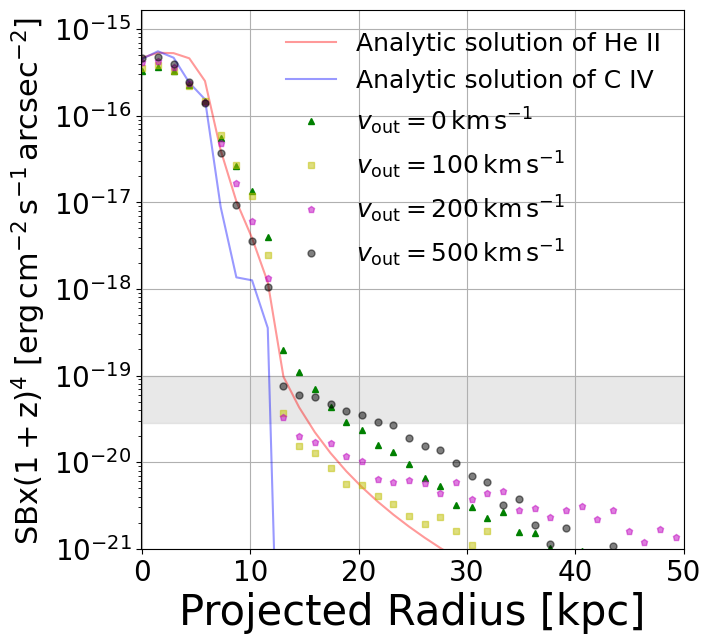

In [37]:
fig = plt.figure(1,figsize=(7,7))
sr_to_arc = (180*3600 / np.pi)**2

plt.yscale('log')

# NaN 방지 (np.sum()이 0일 경우 대비)
HeII_SB_norm = HeII_SB / np.sum(HeII_SB) if np.sum(HeII_SB) != 0 else HeII_SB
CIV_SB_norm = CIV_SB / np.sum(CIV_SB) if np.sum(CIV_SB) != 0 else CIV_SB

plt.plot(HeII_p_radius, HeII_SB/sr_to_arc, 'r-', alpha=0.4, label='Analytic solution of He II')
plt.plot(CIV_p_radius, CIV_SB/sr_to_arc, 'b-', alpha=0.4, label='Analytic solution of C IV')

z = 0
red_shift_f = (1+z)**4

plt.plot(RT_radius_vout_0, photon_number_SB(RT_radius_vout_0, Or_RT_SB_vout_0)[1]/sr_to_arc * red_shift_f , 'g^', ms=5, label=r'$v_{\rm out} = 0 \, \rm km \, s^{-1}$')
plt.plot(RT_radius_vout_1, photon_number_SB(RT_radius_vout_1, Or_RT_SB_vout_1)[1]/sr_to_arc * red_shift_f , 'ys', ms=5, alpha=0.5, label=r'$v_{\rm out} = 100 \, \rm km \, s^{-1}$')
plt.plot(RT_radius_vout_2, photon_number_SB(RT_radius_vout_2, Or_RT_SB_vout_2)[1]/sr_to_arc * red_shift_f , 'mp', ms=5, alpha=0.5, label=r'$v_{\rm out} = 200 \, \rm km \, s^{-1}$')
plt.plot(RT_radius_vout_5, photon_number_SB(RT_radius_vout_5, Or_RT_SB_vout_5)[1]/sr_to_arc * red_shift_f , 'ko', ms=5, alpha=0.5, label=r'$v_{\rm out} = 500 \, \rm km \, s^{-1}$')

plt.fill_between([-0.1,100.1], 1e-19, 2.8e-20, color='lightgray', alpha=0.5)



# photon_number_SB(RT_radius_vout_0, RT_SB_vout_0)

plt.grid(True)
plt.xlabel('Projected Radius [kpc]', fontsize=labelsize)
plt.ylabel(r'$\rm SB x (1+z)^4$ $\rm [erg \, cm^{-2} \,s^{-1}\, arcsec^{-2} ]$ ', fontsize=labelsize-8)
plt.xlim(-0.1,50)
plt.ylim(ymin=1e-21)
plt.tick_params(axis='x', labelsize=ticksize)
plt.tick_params(axis='y', labelsize=ticksize)
plt.legend(fontsize=18,frameon=False)


0.09418665514813082


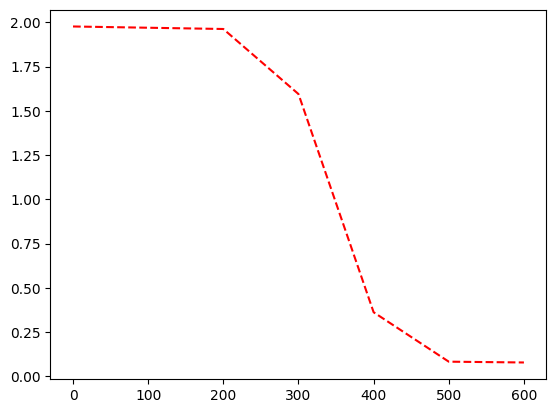

In [38]:
vv = np.array([0,200,300,400,500,600])
doublet_ratio_R = doublet_ratio('H',atom, index, vout, vemit, vrand)
print(doublet_ratio_R)
doublet_ratio_R = np.zeros(len(vv))
# atom , index , vemit, vrand= 79, 14 , 100 , 30
for ii, v in enumerate(vv):
    atom , index , vemit, vrand= 79, 16 , 100 , 30
    doublet_ratio_R[ii] = doublet_ratio('H',atom, index, v, vemit, vrand)

plt.plot(vv , doublet_ratio_R,'r--')

In [39]:
print(np.sum(HeII_den*dr_HeII))


5.28092242521738e+19


In [46]:

def Various_make_parameter(lum,atom):
    path_cloudy = rf'/home/jin/RT/RT_cloudy/L_{lum}/N_H/CIV_Lumin' 
    z_red_Shift = 0
    globals()['{}_radius'.format(atom)] , globals()['{}_radius_kpc'.format(atom)], globals()['dr_{}'.format(atom)] = radius(path_cloudy,atom)
    globals()['{}_lum'.format(atom)] , globals()['{}_emis'.format(atom)] , globals()['{}_den'.format(atom)] = read_file(path_cloudy,atom)
    globals()['{}_p_radius'.format(atom)] , globals()['{}_SB'.format(atom)], globals()['{}_lum_SB'.format(atom)] = SB(z_red_Shift,globals()['{}_radius_kpc'.format(atom)],globals()['{}_emis'.format(atom)]  , globals()['dr_{}'.format(atom)]) # , globals()['rt_radius_kpc_{}'.format(atom)]
    return print("make parameters of {} and L = {}".format(atom , lum))

In [41]:
def Various_RT_make_parameter(lum,v_out, v_emit, v_rand, atom):
    # 기본값 설정
    radius_RT, radius_kpc_RT, SB_RT = np.array([0]), np.array([0]), np.array([0])
    radius_CL, sb_CL = np.array([0]), np.array([0])
    normal_RT, normal_CL = 1, 1  # ZeroDivisionError 방지

    if v_out == 0:
        expand, vout_order = "000", 0
    else:
        expand, vout_order = v_out, 2
    # print(v_emit)
    emit, emit_order = calculate_order_and_value(v_emit)    
    # print(emit,emit_order)
    rand, rand_order = calculate_order_and_value(v_rand)
    # print(rand)

    # 파일 경로 설정
    #ubuntu
    path_rt = (f'/home/jin/RT/RT_main/data_cloudy/data_L{lum}/N_atom000E+00_'
                f'Vexp{expand}E+0{vout_order}_Vemit{emit}E+0{emit_order}_'
                f'tauD000E+00_Vran{rand}E+0{rand_order}radi.dat')
    #window
    # path_rt = (f'/home/jin/RT/RT_main/sb_cloudy/data_RT/N_atom000E+00_'
    #             f'Vexp{expand}E+0{vout_order}_Vemit{emit}E+0{emit_order}_'
    #             f'tauD000E+00_Vran{rand}E+0{rand_order}radi.dat')


    # RT_SB 함수 호출
    rt_output = RT_SB(path_rt)
    if rt_output is not None:
        radius_RT, radius_kpc_RT, SB_RT = rt_output

    # SB_RT 값이 None이거나 비어있을 경우 기본값 설정
    if SB_RT is None or len(SB_RT) == 0:
        SB_RT = np.array([0])
    normal_RT = np.sum(SB_RT) if np.sum(SB_RT) != 0 else 1

    print(f"make parameters of v_rand = {v_rand} km/s, v_exp = {v_out} km/s, v_emit = {v_emit} km/s for {atom}")

    # 추가 데이터 처리
    z_red_Shift = 0
    radius_data = radius(path_LT, atom)
    lum_data = read_file(path_LT, atom)
    sb_data = SB(z_red_Shift, radius_data[1], lum_data[1], radius_data[2])

    if sb_data is not None:
        radius_CL, sb_CL = sb_data[0], sb_data[1]

    # sb_CL 값이 None이거나 비어있을 경우 기본값 설정
    if sb_CL is None or len(sb_CL) == 0:
        sb_CL = np.array([0])
    normal_CL = np.sum(sb_CL) if np.sum(sb_CL) != 0 else 1

    return radius_RT, radius_kpc_RT,  SB_RT/ normal_RT, SB_RT   


def Various_vout_make_parameter(lum,v_out, v_emit ,v_rand):
    for ii in v_out:
        nn = int(ii / 100)
        globals()['RT_radius_vout_{}'.format(nn)] , globals()['RT_radius_kpc_vout_{}'.format(nn)], globals()['RT_SB_vout_{}'.format(nn)] , globals()['Or_RT_SB_vout_{}'.format(nn)]= Various_RT_make_parameter(lum,ii, v_emit, v_rand,'CIV')[:4]
    return print("Make data!!")


def Various_vemit_make_parameter(lum,v_out, v_emit ,v_rand):
    for ii , jj in enumerate (v_emit):
        nn = int(jj / 10)
        globals()['RT_radius_vemit_{}'.format(nn)] , globals()['RT_radius_kpc_vemit_{}'.format(nn)], globals()['RT_SB_vemit_{}'.format(nn)] , globals()['Or_RT_SB_vout_{}'.format(nn)]= Various_RT_make_parameter(lum,v_out, jj, v_rand,'CIV')[:4]
    return print("Make data!!")


def Various_vrand_make_parameter(lum,v_out, v_emit ,v_rand):
    for ii , jj in enumerate(v_rand):
        nn = int(jj / 10)
        globals()['RT_radius_vrand_{}'.format(nn)] , globals()['RT_radius_kpc_vrand_{}'.format(nn)], globals()['RT_SB_vrand_{}'.format(nn)], globals()['Or_RT_SB_vout_{}'.format(nn)] = Various_RT_make_parameter(lum,v_out, v_emit, jj,'CIV')[:4]
    return print("Make data!!")



In [89]:
lum = 43
vout = np.array([0,100,200,300,400,500,800])
vemit = 100
vrand = 30
Various_vout_make_parameter(lum,vout,vemit,vrand)
atom = ['CIV','HeII']
for ii, nn in enumerate (atom):
    Various_make_parameter(lum,nn)

make parameters of v_rand = 30 km/s, v_exp = 0 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 30 km/s, v_exp = 100 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 30 km/s, v_exp = 200 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 30 km/s, v_exp = 300 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 30 km/s, v_exp = 400 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 30 km/s, v_exp = 500 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 30 km/s, v_exp = 800 km/s, v_emit = 100 km/s for CIV
Make data!!
make parameters of CIV and L = 43
make parameters of HeII and L = 43


1.5949013542061363
Luminosity of CIV =  3.1048330936337262e+41
Luminosity of HeII =  2.366578147772257e+41


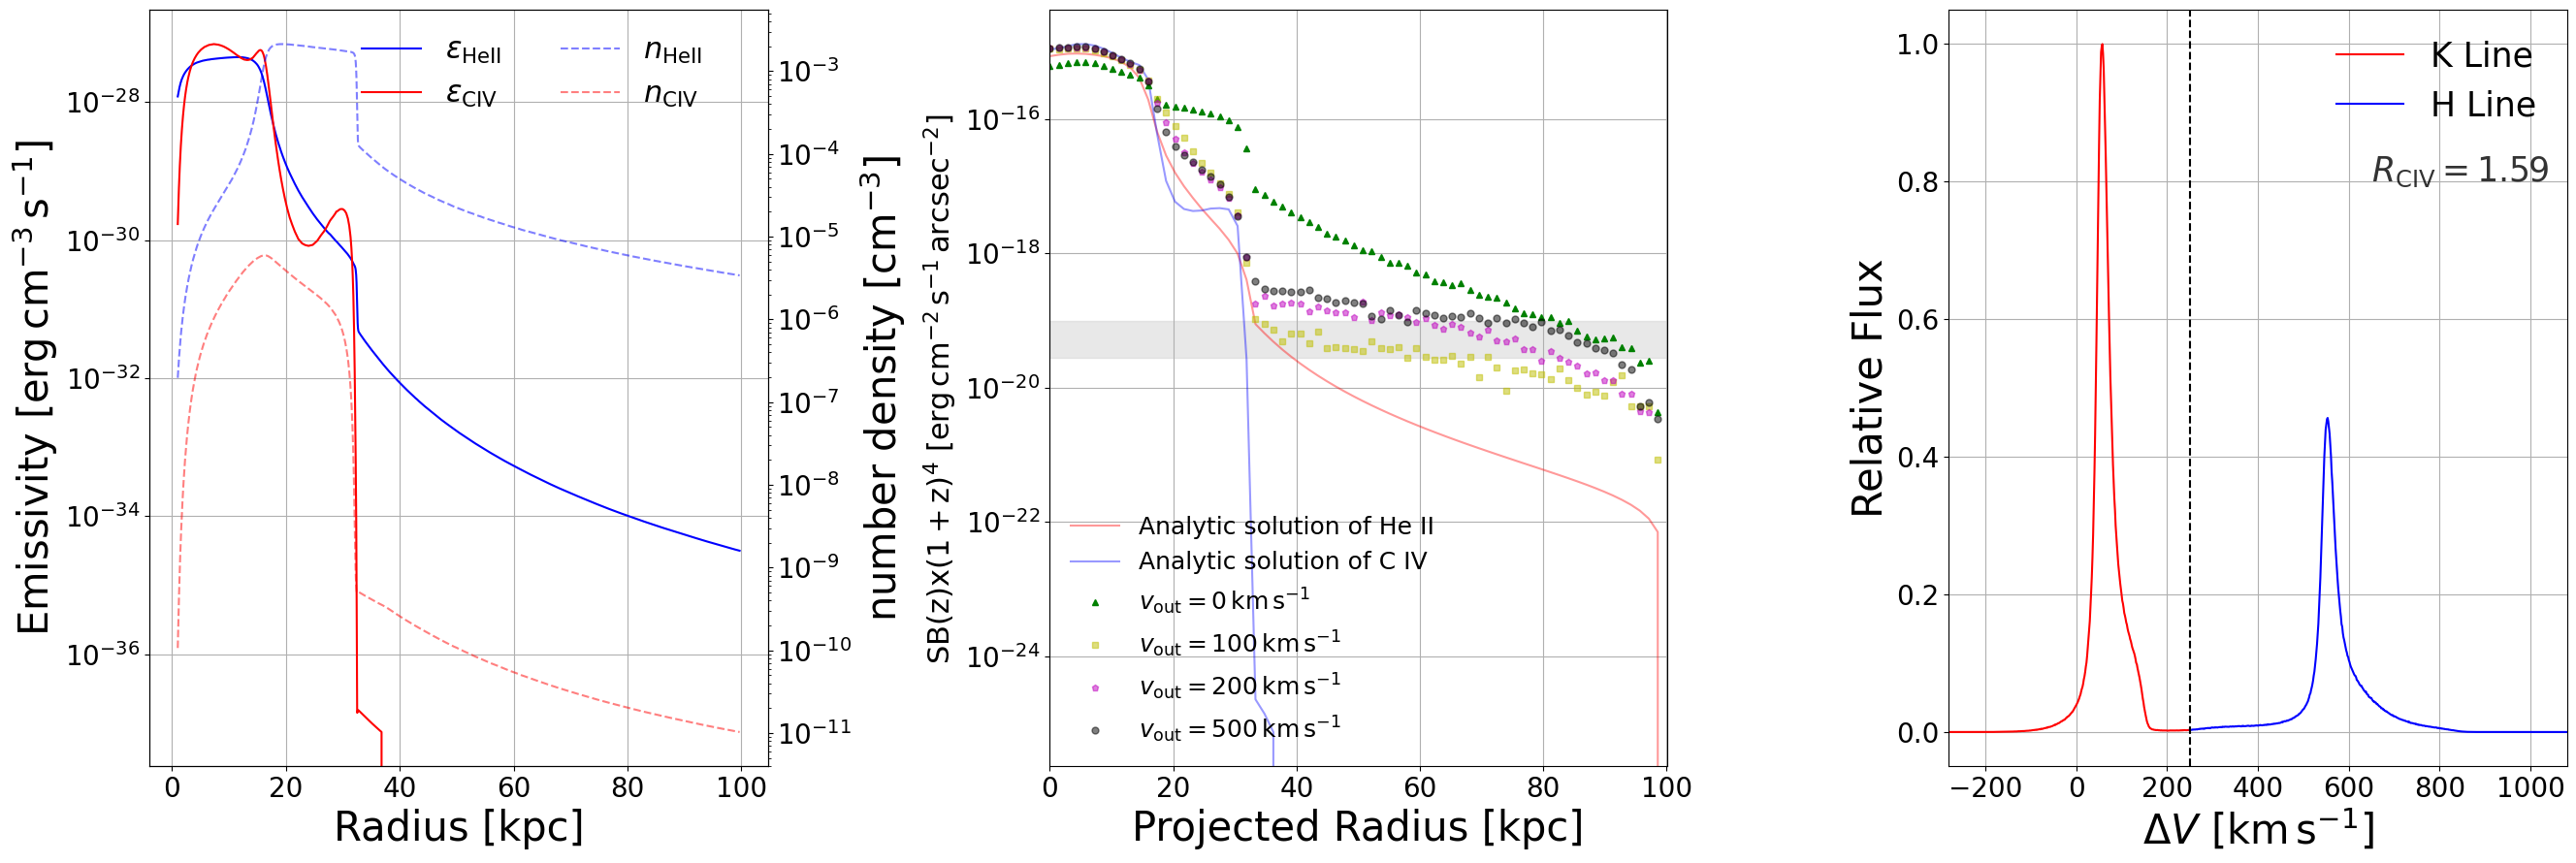

In [90]:
# 전체 figure 및 subplot 설정
fig, ax = plt.subplots(1, 3, figsize=(27, 9))

labelsize = 30
ticksize= 20
legendsize = 22

plt.subplots_adjust(wspace=0.7)

### 첫 번째 subplot ###
ax1 = ax[0]
ax2 = ax1.twinx()  # 오른쪽 y축 추가



ax1.plot(HeII_radius, HeII_emis ,'b-',label=r'$\epsilon_{\rm He II}$')
ax2.plot(HeII_radius, HeII_den, 'b--', alpha=0.5, label=r'$n_{\rm He II}$')

ax1.plot(CIV_radius, CIV_emis ,'r-',label=r'$\epsilon_{\rm CIV}$')
ax2.plot(CIV_radius, CIV_den, 'r--', alpha=0.5, label=r'$n_{\rm CIV}$')

ax1.set_xlabel('Radius [kpc]', fontsize=labelsize)
ax1.set_ylabel(r'$\rm Emissivity \  [\rm erg \, cm^{-3} \, s^{-1}]$', fontsize=labelsize)
ax2.set_ylabel(r'$\rm number \ density \ [\rm cm^{-3}]$', fontsize=labelsize)

ax1.tick_params(axis='x', labelsize=ticksize)
ax1.tick_params(axis='y', labelsize=ticksize)
ax2.tick_params(axis='y', labelsize=ticksize)

ax1.grid(True)

ax1.set_yscale('log')
ax2.set_yscale('log')

# 범례 설정
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0.3, 1.0), ncol=2, fontsize=legendsize, frameon=False)


### 두 번째 subplot ###
sr_to_arc = (180*3600 / np.pi)**2

ax[1].set_yscale('log')

# NaN 방지 (np.sum()이 0일 경우 대비)
HeII_SB_norm = HeII_SB / np.sum(HeII_SB) if np.sum(HeII_SB) != 0 else HeII_SB
CIV_SB_norm = CIV_SB / np.sum(CIV_SB) if np.sum(CIV_SB) != 0 else CIV_SB

ax[1].plot(HeII_p_radius, HeII_SB/sr_to_arc, 'r-', alpha=0.4, label='Analytic solution of He II')
ax[1].plot(CIV_p_radius, CIV_SB/sr_to_arc, 'b-', alpha=0.4, label='Analytic solution of C IV')
# ax[1].plot(Lya_p_radius, Lya_SB/sr_to_arc, 'k-', alpha=0.4, label='Analytic solution of Lya')

z = 0
red_shift_f = (1+z)**4

ax[1].plot(RT_radius_vout_0, photon_number_SB(RT_radius_vout_0, Or_RT_SB_vout_0)[1]/sr_to_arc * red_shift_f , 'g^', ms=5, label=r'$v_{\rm out} = 0 \, \rm km \, s^{-1}$')
ax[1].plot(RT_radius_vout_1, photon_number_SB(RT_radius_vout_1, Or_RT_SB_vout_1)[1]/sr_to_arc * red_shift_f , 'ys', ms=5, alpha=0.5, label=r'$v_{\rm out} = 100 \, \rm km \, s^{-1}$')
ax[1].plot(RT_radius_vout_2, photon_number_SB(RT_radius_vout_2, Or_RT_SB_vout_2)[1]/sr_to_arc * red_shift_f , 'mp', ms=5, alpha=0.5, label=r'$v_{\rm out} = 200 \, \rm km \, s^{-1}$')
ax[1].plot(RT_radius_vout_5, photon_number_SB(RT_radius_vout_5, Or_RT_SB_vout_5)[1]/sr_to_arc * red_shift_f , 'ko', ms=5, alpha=0.5, label=r'$v_{\rm out} = 500 \, \rm km \, s^{-1}$')

# 500
# Limited SB of MUSE -> Augustin et al. 2019
ax[1].fill_between([-0.1,100.1], 1e-19, 2.8e-20, color='lightgray', alpha=0.5)



# photon_number_SB(RT_radius_vout_0, RT_SB_vout_0)

ax[1].grid(True)
ax[1].set_xlabel('Projected Radius [kpc]', fontsize=labelsize)
ax[1].set_ylabel(r'$\rm SB(z) x (1+z)^4$ $\rm [erg \, cm^{-2} \,s^{-1}\, arcsec^{-2} ]$ ', fontsize=labelsize-8)
ax[1].set_xlim(-0.1,100.1)

ax[1].tick_params(axis='x', labelsize=ticksize)
ax[1].tick_params(axis='y', labelsize=ticksize)
ax[1].legend(fontsize=18,frameon=False)



## 3번째 subplot 

atom , index , vout, vemit, vrand= 79, 16 , 300 , 100 , 30
lam_K, spec_tot_K , spec_halo_K = K_H_from_Combine_data('K',atom, index, vout, vemit, vrand) 
lam_H, spec_tot_H , spec_halo_H = K_H_from_Combine_data('H',atom, index, vout, vemit, vrand) 
doublet_ratio_R = doublet_ratio('H',atom, index, vout, vemit, vrand)
print(doublet_ratio_R)
ax[2].plot(lam_to_vel(lam_K), spec_tot_K / max(spec_tot_K),'r-',label='K Line')
ax[2].plot(lam_to_vel(lam_H), spec_tot_H / max(spec_tot_K),'b-',label='H Line')
ax[2].axvline(x=250,ymin=0,ymax=1,linestyle='--',color='k')
ax[2].text(650, (spec_tot_K / max(spec_tot_K)).max()*0.8, s=rf'$R_{{\rm CIV}} = {doublet_ratio_R:.2f}$', size=25,alpha=0.8)


ax[2].grid(True)
ax[2].set_xlabel(r'$\Delta V$ $\rm[km\,s^{-1}]$', fontsize=labelsize)
ax[2].set_ylabel('Relative Flux', fontsize=labelsize)
ax[2].tick_params(axis='x', labelsize=ticksize)
ax[2].tick_params(axis='y', labelsize=ticksize)
ax[2].set_xlim(-280,1080)
ax[2].legend(fontsize=25, frameon=False)
plt.tight_layout()

print('Luminosity of CIV = ' ,CIV_lum)
print('Luminosity of HeII = ' ,HeII_lum)


# plt.savefig(r'/mnt/c/Users/wlsdl/OneDrive/바탕 화면/plot_result.png')

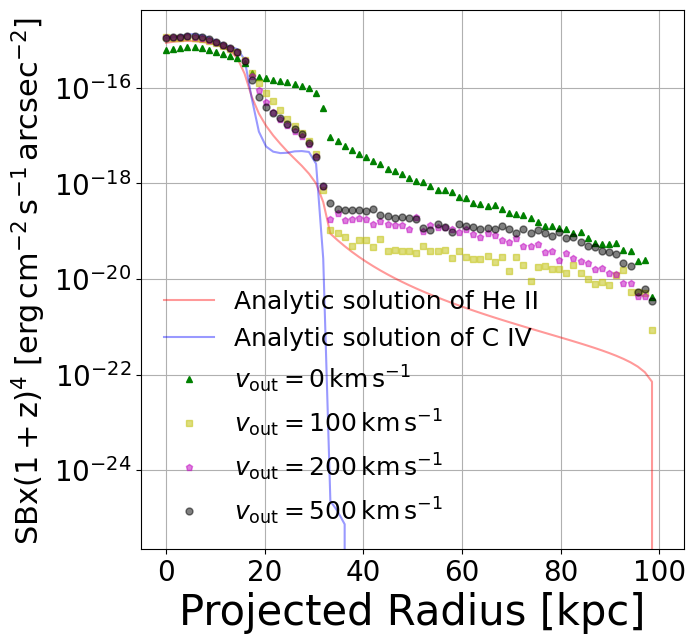

In [77]:
fig = plt.figure(1,figsize=(7,7))
sr_to_arc = (180*3600 / np.pi)**2

plt.yscale('log')

# NaN 방지 (np.sum()이 0일 경우 대비)
HeII_SB_norm = HeII_SB / np.sum(HeII_SB) if np.sum(HeII_SB) != 0 else HeII_SB
CIV_SB_norm = CIV_SB / np.sum(CIV_SB) if np.sum(CIV_SB) != 0 else CIV_SB

plt.plot(HeII_p_radius, HeII_SB/sr_to_arc, 'r-', alpha=0.4, label='Analytic solution of He II')
plt.plot(CIV_p_radius, CIV_SB/sr_to_arc, 'b-', alpha=0.4, label='Analytic solution of C IV')

z = 0
red_shift_f = (1+z)**4

plt.plot(RT_radius_vout_0, photon_number_SB(RT_radius_vout_0, Or_RT_SB_vout_0)[1]/sr_to_arc * red_shift_f , 'g^', ms=5, label=r'$v_{\rm out} = 0 \, \rm km \, s^{-1}$')
plt.plot(RT_radius_vout_1, photon_number_SB(RT_radius_vout_1, Or_RT_SB_vout_1)[1]/sr_to_arc * red_shift_f , 'ys', ms=5, alpha=0.5, label=r'$v_{\rm out} = 100 \, \rm km \, s^{-1}$')
plt.plot(RT_radius_vout_2, photon_number_SB(RT_radius_vout_2, Or_RT_SB_vout_2)[1]/sr_to_arc * red_shift_f , 'mp', ms=5, alpha=0.5, label=r'$v_{\rm out} = 200 \, \rm km \, s^{-1}$')
plt.plot(RT_radius_vout_5, photon_number_SB(RT_radius_vout_5, Or_RT_SB_vout_5)[1]/sr_to_arc * red_shift_f , 'ko', ms=5, alpha=0.5, label=r'$v_{\rm out} = 500 \, \rm km \, s^{-1}$')

# plt.fill_between([-0.1,100.1], 1e-19, 2.8e-20, color='lightgray', alpha=0.5)



# photon_number_SB(RT_radius_vout_0, RT_SB_vout_0)

plt.grid(True)
plt.xlabel('Projected Radius [kpc]', fontsize=labelsize)
plt.ylabel(r'$\rm SB x (1+z)^4$ $\rm [erg \, cm^{-2} \,s^{-1}\, arcsec^{-2} ]$ ', fontsize=labelsize-8)
# plt.xlim(-0.1,50)
# plt.ylim(ymin=1e-21)
plt.tick_params(axis='x', labelsize=ticksize)
plt.tick_params(axis='y', labelsize=ticksize)
plt.legend(fontsize=18,frameon=False)
